# Project: Financial Sentiment Analysis

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

# Datset
import kagglehub

from sklearn.preprocessing import OneHotEncoder

import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

In [29]:
# skip this code

print("TensorFlow version:", tf.__version__)
print("CUDA Available:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
CUDA Available: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
# skip this code

print("TensorFlow Version:", tf.__version__)
print("Detected GPUs:", tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('GPU'))
print(tf.sysconfig.get_build_info())

TensorFlow Version: 2.18.0
Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
OrderedDict({'cpu_compiler': '/usr/lib/llvm-18/bin/clang', 'cuda_compute_capabilities': ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90'], 'cuda_version': '12.5.1', 'cudnn_version': '9', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': False})


## Data Downloading

In [31]:
path = kagglehub.dataset_download("sbhatti/financial-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: /home/asus-creator/.cache/kagglehub/datasets/sbhatti/financial-sentiment-analysis/versions/4


In [32]:
os.listdir('/home/asus-creator/.cache/kagglehub/datasets/sbhatti/financial-sentiment-analysis/versions/4')

['data.csv']

In [33]:
df = pd.read_csv(os.path.join(path, "data.csv"))

## Data Assessment

In [34]:
df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [35]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Net sales decreased to EUR 220.5 mn from EUR 4...,neutral
freq,2,3130


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [37]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [38]:
df['Sentiment'].value_counts()

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

### Data Vizualization

<Axes: >

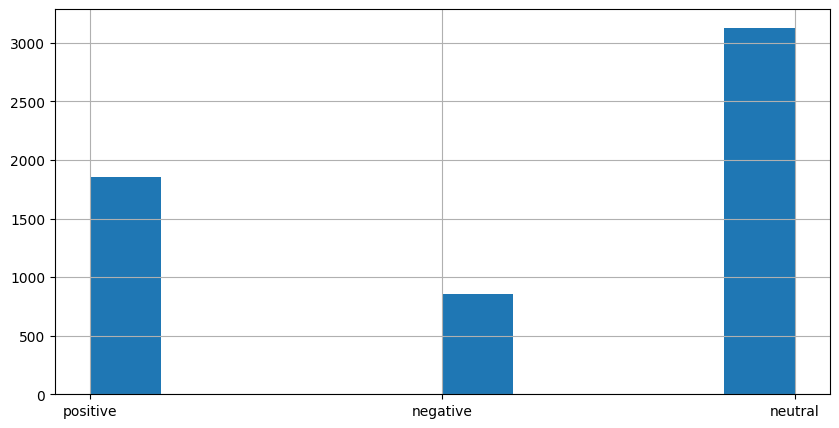

In [39]:
df['Sentiment'].hist(figsize=(10, 5))

## Data Preprocessing

In [40]:
encoder = OneHotEncoder(sparse_output=False)

In [41]:
df_encoded = pd.get_dummies(df, columns=['Sentiment'])

In [42]:
df_encoded

,Sentence,Sentiment_negative,Sentiment_neutral,Sentiment_positive
0,The GeoSolutions technology will leverage Bene...,False,False,True
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",True,False,False
2,"For the last quarter of 2010 , Componenta 's n...",False,False,True
3,According to the Finnish-Russian Chamber of Co...,False,True,False
4,The Swedish buyout firm has sold its remaining...,False,True,False
...,...,...,...,...
5837,RISING costs have forced packaging producer Hu...,True,False,False
5838,Nordic Walking was first used as a summer trai...,False,True,False
5839,"According shipping company Viking Line , the E...",False,True,False
5840,"In the building and home improvement trade , s...",False,True,False


In [43]:
saentiment = df_encoded.drop(columns=['Sentence'])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Sentence'], 
    saentiment,
    test_size=0.2,
    random_state=42,
    stratify=saentiment,
)

In [45]:
X_train.shape

(4673,)

In [46]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text, flags=re.I)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespaces
    return text

In [47]:
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [48]:
X_train.head(10)

4490    financialwire tm is a fully independent  propr...
4217    a total of  jobs will be reduced at the raahe ...
5121    revenue from july to september grew  percent t...
1251    finnish retail software developer aldata solut...
976                viking line has canceled some services
5796    h  h  q  q  in mln euro  unless otherwise stat...
4049    tsla wish had my puts back but see if we can f...
1992    profit before taxes amounted to eur  mn  down ...
5392    union and company officials did not return cal...
5466    the desk will reach its full planned strength ...
Name: Sentence, dtype: object

Vectorizing text data

In [49]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [50]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 89581 stored elements and shape (4673, 5000)>

Convert X_train_tfidf to dense format for inspection

In [51]:
X_train_tfidf_dense = X_train_tfidf.toarray()
feature_names = vectorizer.get_feature_names_out()

X_train_tfidf_dense, feature_names

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['aapl', 'ab', 'ab inbev', ..., 'your', 'zinc', 'zone'],
       dtype=object))

## Model Training

In [52]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  
])

/home/asus-creator/MLC/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743756222.145704   42884 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3601 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [53]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


I0000 00:00:1743756223.318876   45205 service.cc:148] XLA service 0x7b71ec015d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743756223.318895   45205 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-04-04 13:43:43.332675: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743756223.396699   45205 cuda_dnn.cc:529] Loaded cuDNN version 90800


  1/117 ━━━━━━━━━━━━━━━━━━━━ 6:04 3s/step - accuracy: 0.3125 - loss: 1.0989

I0000 00:00:1743756225.885905   45205 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


117/117 ━━━━━━━━━━━━━━━━━━━━ 73s 600ms/step - accuracy: 0.5401 - loss: 0.9854 - val_accuracy: 0.7080 - val_loss: 0.7176
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 38s 321ms/step - accuracy: 0.7936 - loss: 0.5101 - val_accuracy: 0.6963 - val_loss: 0.6970
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.9004 - loss: 0.2583 - val_accuracy: 0.6866 - val_loss: 0.8482
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9096 - loss: 0.1822 - val_accuracy: 0.6813 - val_loss: 0.9944
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.9332 - loss: 0.1206 - val_accuracy: 0.6781 - val_loss: 1.0959
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.9326 - loss: 0.1144 - val_accuracy: 0.6770 - val_loss: 1.2041
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9289 - loss: 0.1053 - val_accuracy: 0.6791 - val_loss: 1.2827
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9309 - loss: 0.1011 - val_acc

## Model Evaluating

In [55]:
y_pred = model.predict(X_test_tfidf)

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step


### Confusion Matrics

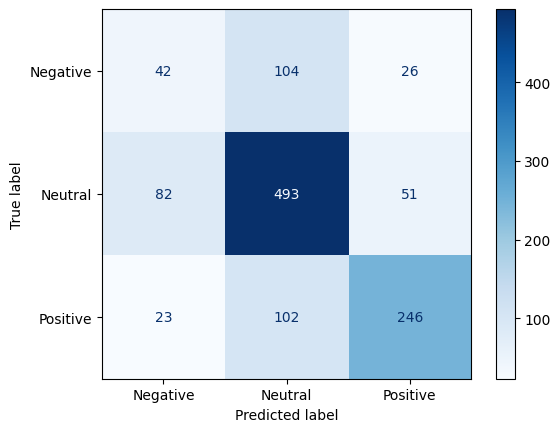

In [82]:
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Classification Report

In [84]:
report = classification_report(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.29      0.24      0.26       172
           1       0.71      0.79      0.74       626
           2       0.76      0.66      0.71       371

    accuracy                           0.67      1169
   macro avg       0.58      0.56      0.57      1169
weighted avg       0.66      0.67      0.66      1169



### Testing

In [92]:
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)
    predicted_class = prediction.argmax(axis=1)[0] 
    if predicted_class == 2:
        return "Positive"
    elif predicted_class == 1:
        return "Neutral"
    else:
        return "Negative"

In [93]:
custom_review = "I absolutely loved this movie! It was fantastic."
print(f"Sentiment: {predict_sentiment(custom_review)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Sentiment: Positive


In [94]:
custom_review = "I hate him he is a bad person."
print(f"Sentiment: {predict_sentiment(custom_review)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Sentiment: Neutral


In [95]:
custom_review = "I am not sure about this product."
print(f"Sentiment: {predict_sentiment(custom_review)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Sentiment: Negative
